# Correlation of Relaxation Times

This is a notebook to understand how relaxation times correlate with each other,
in particular investigating the relaxation of individual molecules.

In [1]:
from pathlib import Path
import numpy as np
import scipy.stats
import pandas
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Dark2
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
import ipywidgets
import itertools
from IPython.display import display
import altair as alt
output_notebook()

Loading BokehJS ...

## Data Import

The data used for this analysis is from a series of simulations studying the dynamics of a Trimer molecule at a pressure of 13.50. 
These simulations are all of equilibrated systems at a range of temperatures. 
For the purposes of this investigation only a single temperature has been studied,
although it is feasilbe to extend this to multiple temperatures.

In [2]:
# Modify these variables to change the simulation being investigated
temperature = '1.35'
pressure = '13.50'

# Select directory data stored and the file within that directory 
infile = '../data/analysis/dynamics.h5'

# Load input file into a pandas dataframe
df = pandas.read_hdf(infile, 'molecular_relaxations').query('temperature==@temperature and pressure==@pressure')
# There are a number of initial configurations in the data, only select the first 
df = df.loc[0]

df = df.drop(columns=['pressure', 'temperature'])


## Visualisation

A simple method of understanding how these timescales relate to one another
is to plot them against each other in a scatter plot.
Where there is some correlation between them this will exist on a straight line throught the figure.
Since the values of the timescales I am investigating are over such a large range,
both the x and y axis have a log scale.

The timescales I am plotting in this figure are the time for a molecule to undergo a certain motion,
with all motions relative to the initial position.
The motions are tabulated below;

- `tau_D04` -> travel a distance of 0.4
- `tau_D1`  -> travel a distance of 1
- `tau_DL04` -> last passage of a distance of 0.4 before reaching 1.0
- `tau_T2`  -> rotate a distance of $\pi/2$
- `tau_T3`  -> rotate a distance of $\pi/3$
- `tau_T4`  -> rotate a distance of $\pi/4$

In [3]:
# Create buttons to select the quantity plotted on each axis 
x_opts = ipywidgets.ToggleButtons(
    options=df.columns,
    description='X axis:',
)
y_opts = ipywidgets.ToggleButtons(
    value=df.columns[1],
    options=df.columns,
    description='Y axis:',
)

@ipywidgets.interact(x=x_opts, y=y_opts)
def create_plot(x, y):
    f = figure(x_axis_type='log', y_axis_type='log', x_axis_label=x, y_axis_label=y)
    f.scatter(x, y, source=df)
    show(f)

interactive(children=(ToggleButtons(description='X axis:', options=('tau_D1', 'tau_D04', 'tau_DL04', 'tau_T2',…

## Quantitation of correlations

While it is nice to look at a picture,
it is difficult to make a fair comparison between two images.
Here I aim to quantify the level of correlation between the timescales.
The metric I have chosen is the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
which is implemented in the `scipy.stats` module as [pearsonr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html).

In [4]:
for x1, x2 in itertools.combinations(df.columns, 2):
    correlation, pValue = scipy.stats.pearsonr(getattr(df, x1), getattr(df, x2))
    print(f'{x1: <8} {x2: <8} {correlation:.2f}')

tau_D1   tau_D04  0.04
tau_D1   tau_DL04 0.00
tau_D1   tau_T2   0.23
tau_D1   tau_T3   0.31
tau_D1   tau_T4   0.37
tau_D04  tau_DL04 0.30
tau_D04  tau_T2   0.01
tau_D04  tau_T3   0.01
tau_D04  tau_T4   0.03
tau_DL04 tau_T2   -0.03
tau_DL04 tau_T3   -0.02
tau_DL04 tau_T4   -0.01
tau_T2   tau_T3   0.65
tau_T2   tau_T4   0.52
tau_T3   tau_T4   0.77


It is notable that the correlation between the last passage time `tau_DL04` and the diffusion time `tau_D1` are so similar.
This really is indicating that the last passage time is a good proxy for diffusive behaviour.
There is still a strong correlation between the last passage time and the relaxation times,
so there is a reasonable argument to be made that these values are all connected in some way. 

In [5]:
selected = ['tau_DL04', 'tau_T2', 'tau_T3', 'tau_T4']
data = df[selected].melt('tau_DL04')
f = figure(x_axis_type='log', y_axis_type='log', x_axis_label='tau_L', y_axis_label='tau_Tn')
f.scatter('tau_DL04', 'value', source=data, color=factor_cmap('variable', palette=Spectral6, factors=['tau_T2', 'tau_T3', 'tau_T4']))
show(f)

In [6]:
f = figure(x_axis_type='linear', y_axis_type='linear', x_axis_label='tau_L', y_axis_label='tau_Tn')
for col, colour in zip(['tau_T2', 'tau_T3', 'tau_T4'], Dark2[3]):
    f.scatter('tau_DL04', col, color=colour, legend=col[4:], source=df, alpha=0.6, size=3)
f.legend.location = 'top_left'
f.legend.click_policy="hide"
show(f)

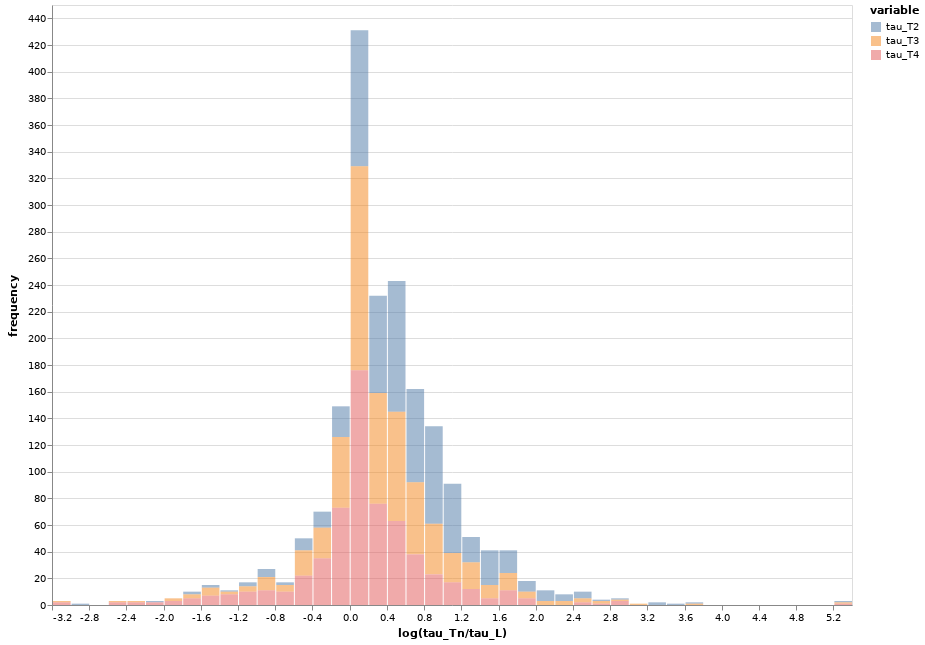

In [7]:
data2=data.copy()
data2.value = np.log10(data2.value/data2.tau_DL04)
c = alt.Chart(data2, width=800, height=600).mark_bar(opacity=0.5).encode(
    color=alt.Color('variable'),
    x=alt.X('value', title='log(tau_Tn/tau_L)', bin=alt.Bin(maxbins=50), stack=None),
    y=alt.Y('count()', title='frequency'),
)
c

In [8]:
len(data2)

1875